In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.stem.lancaster import LancasterStemmer
import community
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pylab as pl
from scipy import sparse
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tools.data_cleansing import clean
from tools.data_exploration import print_email_by_id, emails_sent_distribution, emails_received_distribution,\
body_length_distribution, number_of_recipients_distribution
from tools.data_handling import enrich_emails, load_email_senders, unique_recipients, address_book, load_emails,\
unique_domain_names, name_to_address, mail_body_orig_message
from tools.evaluation import precision
from tools.submission import save_submission

# Loading data

In [2]:
df_emails = enrich_emails()

Reading dataframe from data/enrich_emails.csv


In [3]:
df_emails.head()

,date,body,recipients,sender
mid,,,,
60,2000-07-25 08:14:00,Legal has been assessing the risks of doing bl...,robert.badeer@enron.com murray.o neil@enron.co...,christian.yoder@enron.com
66,2000-08-03 02:56:00,Attached is a spreadsheet to estimate export f...,kim.ward@enron.com robert.badeer@enron.com mur...,heather.dunton@enron.com
74,2000-08-15 05:37:00,Kevin/Bob: Here is a quick rundown on the cons...,robert.badeer@enron.com john.massey@enron.com ...,janel.guerrero@enron.com
80,2000-08-20 14:12:00,check this out and let everyone know what s up...,robert.badeer@enron.com jeff.richter@enron.com,tim.belden@enron.com
83,2000-08-22 08:17:00,Further to your letter to us (addressed to Mr....,pgillman@schiffhardin.com kamarlantes@calpx.co...,christian.yoder@enron.com


# Initialize graph

In [4]:
G=nx.Graph()

In [5]:
for index, row in df_emails.iterrows():
    sender = row["sender"]
    G.add_node("sender")
    recipients = row["recipients"]
    recipients_list = recipients.split()
    for rec in recipients_list:
        if "@" in rec:
            G.add_node(str(rec))
            G.add_edge(sender, str(rec), weight=1/len(recipients_list))

In [6]:
G.number_of_nodes()

9784

In [7]:
G.number_of_edges()

22685

# Graph exploration

In [8]:
G.nodes()[:10] 

['schernick@bear.com',
 'bwallace@zahrsecurities.com',
 'etaphouse@scana.com',
 'keith.considine@enron.com',
 'brian.haufrect@enron.com',
 'janel.guerrero@enron.com',
 'rvillegas@reliant.com',
 't..muzzy@enron.com',
 'hector.mcloughlin@enron.com',
 'regan.rorschach@enron.com']

In [9]:
mean = 0
for edge in G.edges():
    mean += G.get_edge_data(*edge)['weight']
mean = mean / G.number_of_edges()
print(mean)

0.27770691892285715


In [10]:
max = 0
for edge in G.edges():
    if G.get_edge_data(*edge)['weight'] > max:
        max = G.get_edge_data(*edge)['weight']
print(max)

1.0


In [11]:
min = 10 
for edge in G.edges():
    if G.get_edge_data(*edge)['weight'] < max:
        min = G.get_edge_data(*edge)['weight']
print(min)

0.045454545454545456


In [12]:
print(nx.is_connected(G))

False


In [13]:
list_graph = list(nx.connected_component_subgraphs(G))

In [14]:
G_connected = list_graph[0]

In [15]:
G_connected.number_of_nodes()

9781

In [16]:
parts = community.best_partition(G_connected)

In [17]:
values = [parts.get(node) for node in G_connected.nodes()]

# nx.draw_spring(G_connected, cmap = plt.get_cmap('jet'), node_color = values, node_size=10, with_labels=False)

# Constructing a smaller graph

In [32]:
for node in G.nodes():
    if G.degree(node)<=2 and G.degree(node,weight='weight')<=2.1:
        G.remove_node(node)



In [33]:
G.number_of_nodes()

1569

In [34]:
nx.is_connected(G)

True

/Users/Mazz/Documents/MVA/S2-ALTEGRAD/email-classification-challenge/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Mazz/Documents/MVA/S2-ALTEGRAD/email-classification-challenge/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Mazz/Documents/MVA/S2-ALTEGRAD/email-classification-challenge/venv/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Mazz/Do

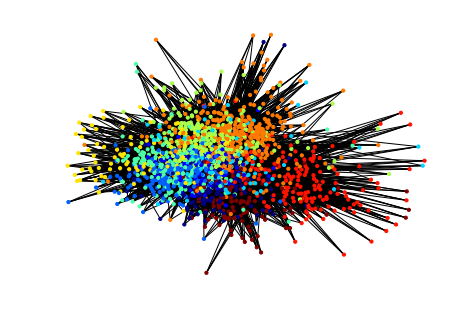

In [35]:
parts = community.best_partition(G)
values = [parts.get(node) for node in G.nodes()]

nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=10, with_labels=False)

# Summary of the smaller graph

#### Number of clusters

In [38]:
output = set()
for x in values:
    output.add(x)
print(output)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


#### Constructing a graph with one node per cluster

In [71]:
G_community=nx.Graph()
for node in G.nodes():
    value = parts.get(node)
    G_community.add_node(value) 
for source_email,sink_email in G.edges():
    source_value, sink_value = parts.get(source_email), parts.get(sink_email)
    if G_community.has_edge(source_value, sink_value):
        # we added this one before, just increase the weight by one
        G_community[source_value][sink_value]['weight'] += G.get_edge_data(source_email,sink_email)['weight']
    else:
        # new edge. add with weight=weight in G
        G_community.add_edge(source_value, sink_value, weight=G.get_edge_data(source_email,sink_email)['weight'])

#### Renaming nodes

In [72]:
d = {}
for node in G_community.nodes():
    d[node] = int(G_community[node][node]['weight'])
print(d)
G_community = nx.relabel_nodes(G_community,d)

{0: 120, 1: 103, 2: 229, 3: 72, 4: 278, 5: 242, 6: 90, 7: 315, 8: 71, 9: 96}


#### Sparsifying Graph

In [73]:
for a, b in G_community.edges():
    if G_community[a][b]['weight'] < 20:
        G_community.remove_edge(a, b)
    if int(a)==int(b) and G_community.has_edge(a,b):
        G_community.remove_edge(a, b)
print(G_community.edges(data='weight'))

[(72, 242, 24.141650413749264), (72, 229, 46.50258958821918), (72, 278, 39.345265675665), (72, 103, 22.00183124441715), (72, 315, 39.40898276733249), (242, 71, 32.675712108270204), (242, 229, 52.58663913095486), (242, 278, 37.65200604688939), (242, 103, 32.98313102492236), (242, 120, 35.462680322546596), (242, 90, 27.248636239405283), (242, 315, 92.30960419626653), (71, 229, 20.438159620597553), (71, 315, 28.956378737964677), (229, 278, 119.7147246385634), (229, 103, 38.12955174755379), (229, 120, 32.074409518647926), (229, 315, 44.07501505188112), (278, 103, 48.28239585151785), (278, 120, 24.165328713494848), (278, 315, 40.69471722537692), (103, 120, 28.853787878787873), (103, 315, 29.71442927349245), (120, 315, 37.05953139274025), (90, 315, 25.565790516986)]


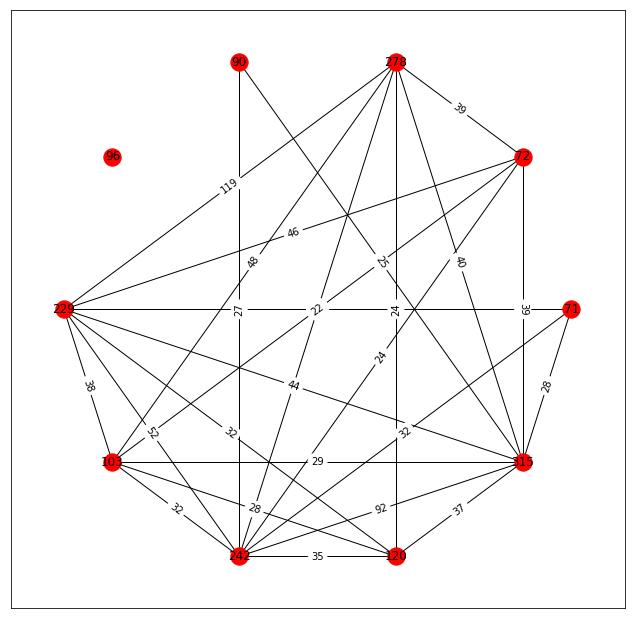

In [74]:
fig=pl.figure(figsize=(11,11))
pos=nx.circular_layout(G_community)
#edges
nx.draw_networkx(G_community,pos,
                edgelist=[e for e in G_community.edges()])


labels = nx.get_edge_attributes(G_community,'weight')
for e in G_community.edges():
    labels[e] = int(labels[e])
#flow label
nx.draw_networkx_edge_labels(G_community, pos,
                        edge_labels=labels, node_size=100000)

#hide axis
fig.gca().axes.get_xaxis().set_ticks([])
fig.gca().axes.get_yaxis().set_ticks([])

pl.show()

In [75]:
G.size(weight='weight')

2867.4501491074484

In [76]:
G_community.size(weight='weight')

1000.0429489262428